This is Will's edit of a notebook originally written by Javier.

# Correlations between H II region parameters

We look at correlations between 6 principal measurements that fall into two groups: 

* Basic parameters: 
    * Size: $L$
    * Ionizing luminosity: $Q(\mathrm{H})$
    * Distance: $D$
* Velocity structure function parameters:
    * Velocity dispersion on plane of sky: $\sigma$
    * Velocity autocorrelation length scale: $\ell_0$
    * Structure function slope in inertial range: $m$

Colab's markdown renderer seems to have a bug that requires some math outside of a list in order to trigger latex parsing: $\alpha$. 

## Original table from Javier

In [1]:
import time
start_time=time.time()
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import lmfit
import statsmodels.api as sm
import linmix
from scipy.stats import pearsonr
import pickle

In [2]:
Region =["NGC 604","NGC 595","Hubble X","Hubble V","30Dor" ,"Carina","NGC 346","M8"   ,"OrionL","OrionS"]
LHa    =[4.46e39  ,2.29e39  ,3.98e38   ,7.41e38   ,5.74e39 ,3.98e39 ,4.67e38  ,2.95e37,1e37    ,1e37    ]
SFR    =[5.3e-3   ,2.6e-3   ,3.1e-4    ,1.5e-4    ,1.3e-2  ,1.0e-2  ,0.0021   ,1.0e-4 ,5.3e-5  ,5.3e-5  ]
n      =[3        ,4        ,5         ,8         ,250     ,500     ,100      ,60     ,150     ,4000    ] 
Diam   =[400      ,400      ,160       ,130       ,98.9    ,5       ,64       , 25    ,5       ,0.6     ]
R      =[200      ,200      ,80        ,65        ,49.4    ,7.5     ,32       ,12.5   ,2.5     ,0.3     ]
Dist   =[840      ,840      ,500       ,500       ,50      ,2.35    ,61.7     ,1.25   ,0.4     ,0.4     ]
siglos =[16.21    ,18.33    ,12.3      ,13.4      ,31.7    ,22.46   ,10.2     ,13.6   ,6       ,6       ]
sigW   =[23.1     ,27.1     ,13.4      ,14.7      ,31.7    ,22.46   ,10.2     ,13.6   ,6       ,6       ]

In [3]:
samples=pd.read_csv('CIresults//list2.csv',header=None)
samples

,0
0,N604H
1,N595
2,HX
3,HV
4,Dor
5,CarC
6,N346
7,M8
8,OrionLH
9,OrionS


In [4]:
CI = {}

for i in range(len(samples)):
    pickle_in = open('Results//CI' + samples[0][i] + '.pkl',"rb")
    df = pickle.load(pickle_in)
    CI[samples[0][i]] = df

SF = {}

for i in range(len(samples)):
    pickle_in = open('Results//SF' + samples[0][i] + '.pkl',"rb")
    df = pickle.load(pickle_in)
    SF[samples[0][i]] = df

Results

In [5]:
CI[samples[0][5]]['result_emcee'].params['sig2'].value

16.740165341646644

In [6]:
CI[samples[0][5]]['result_emcee'].params['sig2'].stderr

1.1302290840142408

In [7]:
i

9

In [8]:
sig = [[0]*(1) for i in range(len(samples))]
siger = [[0]*(1) for i in range(len(samples))]
sig2 = [[0]*(1) for i in range(len(samples))]
sig2er = [[0]*(1) for i in range(len(samples))]
r0 = [[0]*(1) for i in range(len(samples))]
r0er = [[0]*(1) for i in range(len(samples))]
m = [[0]*(1) for i in range(len(samples))]
mer = [[0]*(1) for i in range(len(samples))]

for i in range(len(samples)):
    sig[i] = np.round(CI[samples[0][i]]['result_emcee'].params['sig2'].value,4)**0.5
    siger[i] = np.round(CI[samples[0][i]]['result_emcee'].params['sig2'].stderr,4)**0.5
    sig2[i] = np.round(CI[samples[0][i]]['result_emcee'].params['sig2'].value,4)
    r0[i] = np.round(CI[samples[0][i]]['result_emcee'].params['r0'].value,4)
    m[i] = np.round(CI[samples[0][i]]['result_emcee'].params['m'].value,4)
    sig2er[i] = np.round(CI[samples[0][i]]['result_emcee'].params['sig2'].stderr,4)
    r0er[i] = np.round(CI[samples[0][i]]['result_emcee'].params['r0'].stderr,4)
    mer[i] = np.round(CI[samples[0][i]]['result_emcee'].params['m'].stderr,4)
  

In [9]:
data = pd.DataFrame(
    {
       "Region": Region,
       "LHa": LHa,
       "SFR": SFR,
       "n": n,
       "L [pc]": Diam,
       "R [pc]": R,
       "Dist [kpc]": Dist,
       "sig2 [km/s]": sig2,
       "sig2er": sig2er,
       "sig [km/s]": sig,
       "siger": siger,
       "m": m,
       "mer": mer,
       "r0 [pc]": r0,
       "r0er": r0er,
       "siglos [km/s]": siglos,
      
    },
)

Checar que los tipos de las columnas sean adecuadas:

In [10]:
data.dtypes

Region            object
LHa              float64
SFR              float64
n                  int64
L [pc]           float64
R [pc]           float64
Dist [kpc]       float64
sig2 [km/s]      float64
sig2er           float64
sig [km/s]       float64
siger            float64
m                float64
mer              float64
r0 [pc]          float64
r0er             float64
siglos [km/s]    float64
dtype: object

In [11]:
data

,Region,LHa,SFR,n,L [pc],R [pc],Dist [kpc],sig2 [km/s],sig2er,sig [km/s],siger,m,mer,r0 [pc],r0er,siglos [km/s]
0,NGC 604,4.460000e+39,0.005300,3,400.0,200.0,840.00,80.9339,25.3100,8.996327,5.030904,0.8225,0.2033,9.1250,2.9823,16.21
1,NGC 595,2.290000e+39,0.002600,4,400.0,200.0,840.00,56.4551,1.6947,7.513661,1.301806,1.2927,0.0468,11.6951,0.4549,18.33
2,Hubble X,3.980000e+38,0.000310,5,160.0,80.0,500.00,15.5523,1.5078,3.943640,1.227925,0.9485,0.1253,3.9070,0.2892,12.30
3,Hubble V,7.410000e+38,0.000150,8,130.0,65.0,500.00,10.4604,0.7521,3.234254,0.867237,0.7361,0.0938,3.4236,0.3305,13.40
4,30Dor,5.740000e+39,0.013000,250,98.9,49.4,50.00,350.8784,21.5905,18.731748,4.646558,0.8414,0.0377,4.6033,0.4381,31.70
5,Carina,3.980000e+39,0.010000,500,5.0,7.5,2.35,16.7402,1.1302,4.091479,1.063109,1.3687,0.2960,0.6633,0.0800,22.46
6,NGC 346,4.670000e+38,0.002100,100,64.0,32.0,61.70,38.0352,1.0980,6.167268,1.047855,0.7892,0.0261,1.9095,0.0980,10.20
7,M8,2.950000e+37,0.000100,60,25.0,12.5,1.25,7.2912,0.8461,2.700222,0.919837,1.1291,0.0911,1.0060,0.1764,13.60
8,OrionL,1.000000e+37,0.000053,150,5.0,2.5,0.40,5.9756,0.5874,2.444504,0.766420,1.7252,0.2408,0.7348,0.1716,6.00
9,OrionS,1.000000e+37,0.000053,4000,0.6,0.3,0.40,16.9233,0.9716,4.113794,0.985698,1.0692,0.0178,0.0919,0.0066,6.00


## Change to log scale for most parameters

El analisis de la mayoría de las columnas sería mejor en escala logarítmica porque varían por varios ordenes de magnitud.  Entonces, hacemos una nueva versión de la tabla así. Dejamos la $m$ en escala lineal porque no varía mucho.

In [12]:
cols = data.columns
logdata = data.copy()
for col in cols:
    if col not in ["Region", "m", "mer", "r0er", "siger",  "sig2er",]:
        logdata[col] = np.round(np.log10(logdata[col]), 2)
        logdata.rename(columns={col: f"log {col}"}, inplace=True)
# Some minor changes to column names
logdata.rename(
    columns={
        "log LHa": "log L(H) [erg s^-1]",
        }, 
    inplace=True)
logdata

,Region,log L(H) [erg s^-1],log SFR,log n,log L [pc],log R [pc],log Dist [kpc],log sig2 [km/s],sig2er,log sig [km/s],siger,m,mer,log r0 [pc],r0er,log siglos [km/s]
0,NGC 604,39.65,-2.28,0.48,2.60,2.30,2.92,1.91,25.3100,0.95,5.030904,0.8225,0.2033,0.96,2.9823,1.21
1,NGC 595,39.36,-2.59,0.60,2.60,2.30,2.92,1.75,1.6947,0.88,1.301806,1.2927,0.0468,1.07,0.4549,1.26
2,Hubble X,38.60,-3.51,0.70,2.20,1.90,2.70,1.19,1.5078,0.60,1.227925,0.9485,0.1253,0.59,0.2892,1.09
3,Hubble V,38.87,-3.82,0.90,2.11,1.81,2.70,1.02,0.7521,0.51,0.867237,0.7361,0.0938,0.53,0.3305,1.13
4,30Dor,39.76,-1.89,2.40,2.00,1.69,1.70,2.55,21.5905,1.27,4.646558,0.8414,0.0377,0.66,0.4381,1.50
5,Carina,39.60,-2.00,2.70,0.70,0.88,0.37,1.22,1.1302,0.61,1.063109,1.3687,0.2960,-0.18,0.0800,1.35
6,NGC 346,38.67,-2.68,2.00,1.81,1.51,1.79,1.58,1.0980,0.79,1.047855,0.7892,0.0261,0.28,0.0980,1.01
7,M8,37.47,-4.00,1.78,1.40,1.10,0.10,0.86,0.8461,0.43,0.919837,1.1291,0.0911,0.00,0.1764,1.13
8,OrionL,37.00,-4.28,2.18,0.70,0.40,-0.40,0.78,0.5874,0.39,0.766420,1.7252,0.2408,-0.13,0.1716,0.78
9,OrionS,37.00,-4.28,3.60,-0.22,-0.52,-0.40,1.23,0.9716,0.61,0.985698,1.0692,0.0178,-1.04,0.0066,0.78


Uncertainties Log Space

In [13]:
logdata['mer']=(data['mer']/data['m'])*0.434

In [14]:
logdata['r0er']=(data['r0er']/data['r0 [pc]'])*0.434

In [15]:
logdata['siger']=(data['siger']/data['sig [km/s]'])*0.434

In [16]:
logdata['sig2er']=(data['sig2er']/data['sig2 [km/s]'])*0.434

Make the label text bigger on the figures

In [17]:
sns.set_context("talk")

Repeat the pair plot of correlations between columns with the log-scale quantities. Use color to indicate the distance to the regions.

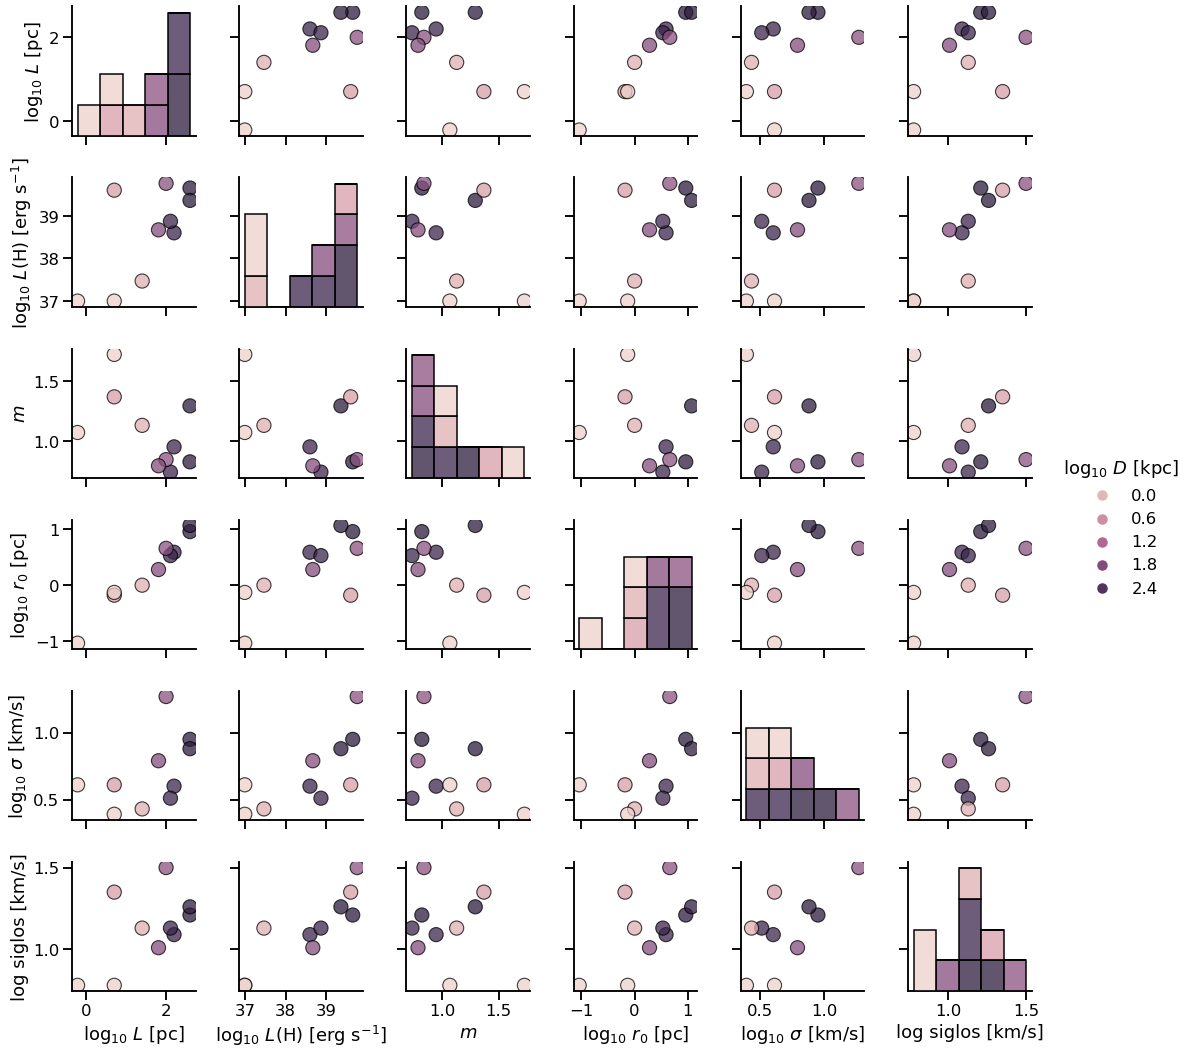

In [18]:
selected_vars = [ "log L [pc]","log L(H) [erg s^-1]", "log Dist [kpc]", "m", "log r0 [pc]", "log sig [km/s]", "log siglos [km/s]"]
plotdata = logdata[selected_vars].rename(
    columns={
        # Switch column names to use latex formatting to improve axis labels
        "log L [pc]": r"$\log_{10}\ L$ [pc]", 
        "log L(H) [erg s^-1]": r"$\log_{10}\ L(\mathrm{H})$ [erg s$^{-1}$]", 
        "m": "$m$", 
        "log r0 [pc]": r"$\log_{10}\ r_0$ [pc]", 
        "log sig [km/s]": r"$\log_{10}\ \sigma$ [km/s]", 
        "log Dist [kpc]": r"$\log_{10}\ D$ [kpc]",
    },
)

sns.pairplot(plotdata, 
             hue=r"$\log_{10}\ D$ [kpc]",
             plot_kws=dict(alpha=0.75, s=200, edgecolor="k"), 
             diag_kind='hist',
             diag_kws= dict(multiple='stack'),
             );

figname = "strucfunc-correlations"
# Save PDF and JPG versions of the figure
#plt.gcf().savefig(f"{figname}.pdf")
#plt.gcf().savefig(f"{figname}.jpg")

## Correlation coefficients

Calculate [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), $r$, between each pair of variables:

In [19]:
logdata[selected_vars].corr()

,log L [pc],log L(H) [erg s^-1],log Dist [kpc],m,log r0 [pc],log sig [km/s],log siglos [km/s]
log L [pc],1.000000,0.674686,0.923364,-0.488579,0.978519,0.484508,0.555372
log L(H) [erg s^-1],0.674686,1.000000,0.714755,-0.418896,0.724332,0.711118,0.875549
log Dist [kpc],0.923364,0.714755,1.000000,-0.601485,0.888121,0.484911,0.477683
m,-0.488579,-0.418896,-0.601485,1.000000,-0.347830,-0.454012,-0.309557
log r0 [pc],0.978519,0.724332,0.888121,-0.347830,1.000000,0.528864,0.608116
log sig [km/s],0.484508,0.711118,0.484911,-0.454012,0.528864,1.000000,0.661643
log siglos [km/s],0.555372,0.875549,0.477683,-0.309557,0.608116,0.661643,1.000000


So the results for correlations between the basic parameters are what we would expect:

- Size is moderately correlated with luminosity ($r = 0.67$).  The correlation is only weak because size will also depend on ambient density and the age of the region. 
- Size is highly correlated with distance ($r = 0.92$).  This is just a selection effect due to the fact that we tend to choose regions that have an angular size that matches our instruments. 
- Luminosity–distance correlation is the weakest ($r = 0.71$), and can be explained as being due to the previous two.



The correlations of the structure function parameters with the basic parameters are very interesting:
- Autocorrelation length scale, $r_0$, is *highly* correlated ($r = 0.96$) with region size, $L$.  Looking at the graph, the relation seems to be approximately linear with $\ell_0 \approx 0.1 L$.  How much of this correlation is real and how much is down to selection effects is something we need to consider carefully.
- Velocity dispersion, $\sigma$, is well correlated ($r = 0.71$) with luminosity, $L(\mathrm{Ha})$.  
- The structure function slope $m$ is well correlated ($r = 0.73$) with distance.  This is mainly because $m \approx 1.6$ for all the distant regions observed with TAURUS and ISIS, but is around $m = 1$ for all the nearby regions.  I suspect that this is mainly a data quality issue: we observe very little of the inertial range in the distant regions, so the determination of $m$ is probably not so reliable.  But I am not sure why this would tend to bias $m$ towards high values.  

## Significance tests

We can calculate the statistical significance of the correlations by using the Student t-statistic.  We test the null hypothesis that a given pair of variables is truly uncorrelated ($r = 0$) for the underlying population and that the observed $r$ for our sample of $N = 9$ sources arises solely by chance.  We want to calculate the $p$-value, which is the probability of obtaining $r$ greater than or equal to the observed value, given that there is no true correlation.  A small value of $p$ means that the null hypothesis can be rejected at a certain confidence level.  

First we calculate the t-statistic from the Pearson correlation coefficient:
$$
t = r \, \left(\frac{N - 2}{1 - r^2}\right)^{1/2}
$$
Then, we use the cumulative distribution function (CDF) of the t-distribution with $N - 1$ degrees of freedom to find the p-value. 

In [20]:
def tstatistic(r, n):
    """Compute Student t statistic for null hypothesis of no correlation
    for an observed Pearson correlation of `r` from `n` samples
    """
    return r*np.sqrt((n - 2) / (1 - r**2))

In [21]:
import scipy.stats

In [22]:
def p_from_t(t, n):
    """Compute 1-sided p-value from Student statistic `t` with `n` observations"""
    # sf is survival function: 1 - CDF
    return scipy.stats.t.sf(t, n-1)
    

In [23]:
N = 9
rvals = np.array([0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.779, 0.8, 0.9, 0.908, 0.95, 0.981])
tvals = tstatistic(rvals, N)
pvals = p_from_t(tvals, N)
pd.DataFrame(
    {"r": rvals, "t": tvals, "p": pvals}
)

,r,t,p
0,0.000,0.000000,5.000000e-01
1,0.200,0.540062,3.019294e-01
2,0.400,1.154701,1.407685e-01
3,0.500,1.527525,8.257494e-02
4,0.600,1.984313,4.124805e-02
5,0.700,2.593355,1.597303e-02
6,0.779,3.287020,5.535582e-03
7,0.800,3.527668,3.879201e-03
8,0.900,5.462793,2.997718e-04
9,0.908,5.733922,2.184923e-04


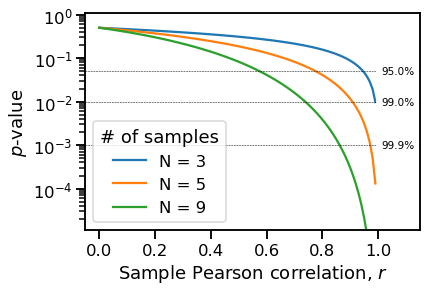

In [24]:
fig, ax = plt.subplots()
for N in 3, 5, 9:
    rvals = np.linspace(0.0, 1.0, 100, endpoint=False)
    tvals = tstatistic(rvals, N)
    pvals = p_from_t(tvals, N)
    ax.plot(rvals, pvals, label=f"N = {N}")
for p0 in 0.05, 0.01, 0.001:
    ax.axhline(p0, color="k", ls="--", lw=0.5)
    ax.text(1.07, p0, f"{100*(1-p0):.1f}%", 
            va="center", ha="center", fontsize="xx-small", 
            bbox={"color": "w"})
ax.legend(title="# of samples")
ax.set(
    xlabel="Sample Pearson correlation, $r$",
    ylabel="$p$-value",
    yscale="log",
    xlim=[-0.05, 1.15],
    ylim=[1.1e-5, 1.1],
);

I have marked confidence levels for nominal $p$-values of 0.05, 0.01, and 0.001, which are often used to judge significance.   This implies that all the correlations that we listed above are highly significant.  For instance, the correlation of $\sigma$ with luminosity, with $r=0.77$, has $p = 0.011$, so close to the 99% confidence level. 

Despite the good correlation, there is a factor of 4 difference in $\sigma$ between Carina and 30~Dor, despite similar luminosities.  **Need to check these luminostiy values**. 

In [25]:
logdata

,Region,log L(H) [erg s^-1],log SFR,log n,log L [pc],log R [pc],log Dist [kpc],log sig2 [km/s],sig2er,log sig [km/s],siger,m,mer,log r0 [pc],r0er,log siglos [km/s]
0,NGC 604,39.65,-2.28,0.48,2.60,2.30,2.92,1.91,0.135722,0.95,0.242700,0.8225,0.107273,0.96,0.141843,1.21
1,NGC 595,39.36,-2.59,0.60,2.60,2.30,2.92,1.75,0.013028,0.88,0.075194,1.2927,0.015712,1.07,0.016881,1.26
2,Hubble X,38.60,-3.51,0.70,2.20,1.90,2.70,1.19,0.042076,0.60,0.135134,0.9485,0.057333,0.59,0.032125,1.09
3,Hubble V,38.87,-3.82,0.90,2.11,1.81,2.70,1.02,0.031204,0.51,0.116373,0.7361,0.055304,0.53,0.041897,1.13
4,30Dor,39.76,-1.89,2.40,2.00,1.69,1.70,2.55,0.026705,1.27,0.107657,0.8414,0.019446,0.66,0.041304,1.50
5,Carina,39.60,-2.00,2.70,0.70,0.88,0.37,1.22,0.029301,0.61,0.112768,1.3687,0.093858,-0.18,0.052344,1.35
6,NGC 346,38.67,-2.68,2.00,1.81,1.51,1.79,1.58,0.012529,0.79,0.073739,0.7892,0.014353,0.28,0.022274,1.01
7,M8,37.47,-4.00,1.78,1.40,1.10,0.10,0.86,0.050363,0.43,0.147843,1.1291,0.035017,0.00,0.076101,1.13
8,OrionL,37.00,-4.28,2.18,0.70,0.40,-0.40,0.78,0.042662,0.39,0.136071,1.7252,0.060577,-0.13,0.101353,0.78
9,OrionS,37.00,-4.28,3.60,-0.22,-0.52,-0.40,1.23,0.024917,0.61,0.103990,1.0692,0.007225,-1.04,0.031169,0.78


In [26]:
#logdata=logdata.drop(9, axis=0)
#logdata

r0 vs m

In [27]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log r0 [pc]', 'r0er','m', 'mer']]

In [28]:
Y=np.log10(Y)

[Text(0, 0.5, 'log$ m$'), Text(0.5, 0, 'log$ r_{0}$ [pc]')]

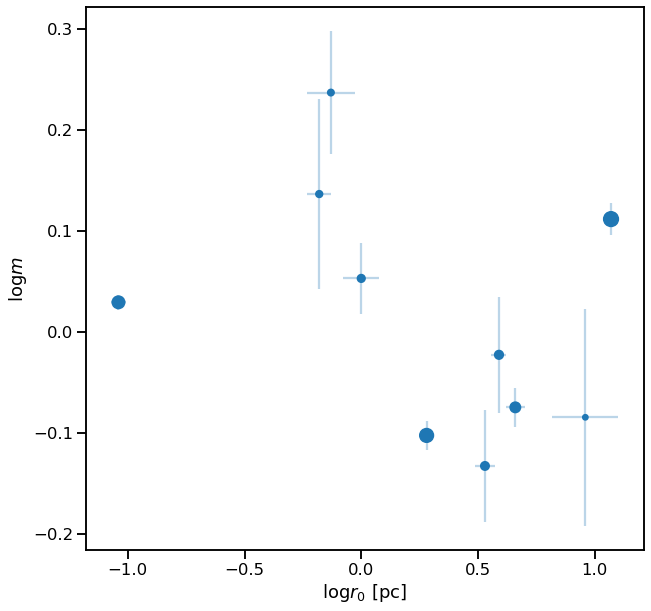

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log$ r_{0}$ [pc]", ylabel=r"log$ m$",
)
#ax.set_aspect("equal")
#sns.despine()

In [30]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [31]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.0046593  1.0113111  0.99728652 1.1112357  1.00836801 1.00071235]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00277196 1.00178451 1.00309433 1.06270769 1.00427723 0.99867481]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00351707 1.0031254  1.0017317  1.01303973 1.00287335 1.00017461]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00216655 1.00405657 1.00379421 1.0058541  1.00388768 0.99968121]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00025248 0.99963903 1.00259494 1.00745132 1.0037436  0.99836043]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00095388 0.99932794 1


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00046478 1.00021553 1.00170303 1.00065064 0.99994306 0.99984514]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00048524 1.00016579 1.00169602 1.00083288 0.99994458 0.99989008]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00049354 1.00017476 1.00142886 1.0009087  0.99994571 0.99989342]


In [32]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
dfchain

,alpha,beta,sigsqr,pi,mu,tausqr,mu0,usqr,wsqr,ximean,xisig,corr
0,0.017664,-0.121063,0.013290,"[0.8152663886319139, 0.18473361136808597]","[0.17377926939634664, 0.7365396163523904]","[0.3966989054763281, 1.313437642341244]",0.036240,0.343554,0.574621,0.277740,0.783421,-0.635324
1,0.035728,-0.100036,0.012474,"[0.866183107412498, 0.133816892587502]","[0.09586746271430165, 0.391857543580047]","[0.36025860208824306, 0.3036333057288754]",0.134106,0.470995,1.214793,0.135476,0.602359,-0.474816
2,0.044973,-0.091980,0.021631,"[0.9673981551581481, 0.03260184484185187]","[0.5621845199116715, 0.4142521314277813]","[0.4326002692287161, 9.374698849532335]",0.329537,0.247890,0.078984,0.557362,0.851363,-0.469976
3,0.072002,0.047190,0.025085,"[0.7662090031957557, 0.23379099680424442]","[0.19165217187178454, 0.28416271387402364]","[0.47009786267003134, 0.06516038056219124]",0.047620,0.088718,0.201597,0.213280,0.613971,0.179944
4,0.046176,-0.014582,0.009653,"[0.6986605819683053, 0.3013394180316948]","[0.08480321472894282, -0.4972837788969119]","[0.3434400879484812, 0.46654627657308817]",-0.506919,0.100713,0.915766,-0.090603,0.672214,-0.099280
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.006817,-0.015907,0.009623,"[0.7724338022698279, 0.22756619773017206]","[0.1139012712815754, -0.3546449880709516]","[0.14968572233712482, 0.2995720012296533]",-0.316960,0.090316,0.525771,0.007276,0.471577,-0.076243
9996,-0.012815,-0.016240,0.024714,"[0.7831455570813567, 0.21685444291864334]","[0.6844271445225568, -0.8756634546937279]","[0.4168729927580686, 4.522258148444847]",-0.184606,0.290186,1.870319,0.346115,1.311673,-0.134274
9997,0.040055,-0.134321,0.020286,"[0.8773464290780097, 0.12265357092199022]","[0.3342573368274106, -0.4423648830409457]","[0.7364494259121805, 0.8708580167612566]",0.386378,0.409956,0.849007,0.239002,0.904345,-0.648913
9998,0.102697,-0.072422,0.014260,"[0.7392838093858538, 0.26071619061414614]","[-0.040235426576618494, -0.07934785638770137]","[1.504444789070471, 0.2037572282574725]",0.330650,0.457449,0.169148,-0.050433,1.079643,-0.547796


In [33]:
dfchain.describe()

,alpha,beta,sigsqr,mu0,usqr,wsqr,ximean,xisig,corr
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.028115,-0.055066,0.027680,0.277619,0.266532,0.541110,0.288836,1.048824,-0.240802
std,0.060632,0.092997,0.029596,0.498451,0.163071,0.533873,0.246122,10.379924,0.356282
min,-0.375275,-0.865436,0.002227,-2.017640,0.000150,0.000338,-1.052211,0.326275,-0.999985
25%,-0.007179,-0.105855,0.012729,-0.029006,0.126596,0.187180,0.136304,0.614228,-0.511892
50%,0.027331,-0.051228,0.019910,0.285846,0.247634,0.379011,0.290708,0.736826,-0.271071
75%,0.063005,-0.000241,0.031903,0.583455,0.397943,0.721931,0.441029,0.914268,-0.001298
max,0.680534,0.742865,0.952872,2.796685,0.598106,7.961073,1.620692,991.667706,0.999962


In [34]:
pearsonr(X, Y)

(-0.366523237675038, 0.29753551711315485)

In [35]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,0.274000,0.055729,0.014774,0.046610
std,0.631545,0.039598,0.120267,0.034507
min,-1.040000,0.016881,-0.133063,0.007225
25%,-0.097500,0.031408,-0.082397,0.016646
50%,0.405000,0.041600,0.003048,0.045160
75%,0.642500,0.070162,0.096806,0.059766
max,1.070000,0.141843,0.236839,0.107273


[Text(0, 0.5, 'log$ m$'), Text(0.5, 0, 'log$ r_{0}$ [pc]')]

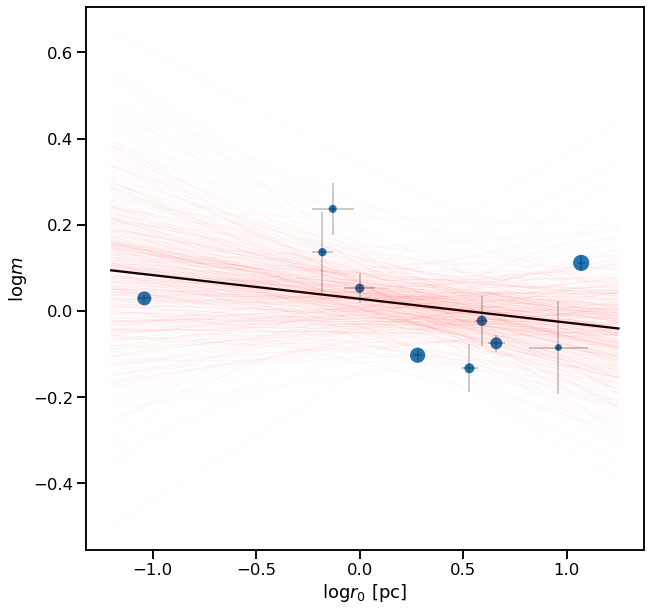

In [36]:
vmin, vmax = -1.2, 1.25
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log$ r_{0}$ [pc]", ylabel=r"log$ m$",
)

In [37]:
dfchain["alpha"].mean(),dfchain["beta"].mean()

(0.028114531106518785, -0.05506589613808678)

In [38]:
dfchain["alpha"].std(),dfchain["beta"].std()

(0.06063170964612184, 0.0929969040521011)

In [39]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      m   R-squared:                       0.021
Model:                            WLS   Adj. R-squared:                 -0.101
Method:                 Least Squares   F-statistic:                    0.1727
Date:                Thu, 28 Oct 2021   Prob (F-statistic):              0.689
Time:                        20:50:27   Log-Likelihood:                 6.0007
No. Observations:                  10   AIC:                            -8.001
Df Residuals:                       8   BIC:                            -7.396
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0071      0.026      0.268      

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


r0 vs sig

In [40]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log r0 [pc]', 'r0er','log sig [km/s]', 'siger']]

[Text(0, 0.5, 'log sig [km/s]'), Text(0.5, 0, 'log$ r_{0}$ [pc]')]

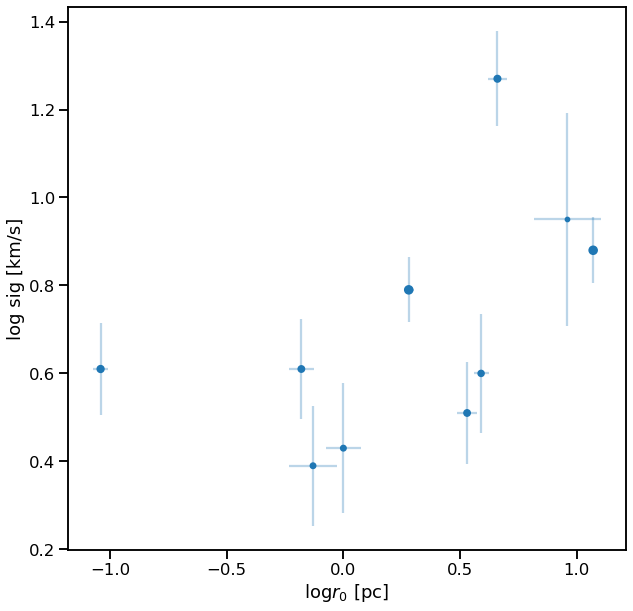

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log$ r_{0}$ [pc]", ylabel=r"log sig [km/s]",
)
#ax.set_aspect("equal")
#sns.despine()

In [42]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [43]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99253519 0.99970303 1.00016974 1.09056891 0.99781971 0.99414062]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.9989723  1.00110941 0.99554392 1.00806426 0.99653626 1.00537947]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99957733 1.00135114 0.99853053 1.0030355  0.99824396 1.00074289]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00043188 0.99912258 1.00066907 0.99861983 1.00017037 1.00063302]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99899906 0.99861954 0.99955201 0.99939055 1.00013578 0.99872771]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99924779 0.99916693 0


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00013234 1.00011503 1.00008669 1.00051258 0.99997148 1.00061847]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00012857 1.00010523 1.00027417 1.00065793 0.99997069 1.00075872]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00019553 1.0000506  1.00025951 1.00048688 0.99997132 1.00079621]


In [44]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
dfchain

,alpha,beta,sigsqr,pi,mu,tausqr,mu0,usqr,wsqr,ximean,xisig,corr
0,0.874448,0.173655,0.149967,"[0.3502672635948265, 0.6497327364051734]","[-0.09227796855378129, 0.12230516240850908]","[0.5110189085215621, 0.11951485878473879]",-1.053673,0.288138,0.432218,0.047144,0.516841,0.225780
1,0.679777,0.451160,0.168136,"[0.6091355120198433, 0.3908644879801569]","[-0.41167194724862516, 0.21456717847844414]","[2.101048676945108, 0.08823176133004403]",0.163064,0.091310,0.428147,-0.166897,1.186458,0.793850
2,0.406440,0.149229,0.473148,"[0.20574695478428875, 0.7942530452157113]","[0.11673687859814376, 0.3364273951999077]","[0.2638980421380523, 0.32943250944429003]",0.432805,0.505132,0.748617,0.291227,0.569066,0.122527
3,0.886366,-0.145664,0.323822,"[0.18667759371730908, 0.8133224062826909]","[0.3991314490696849, 0.11337799399628745]","[0.9472075248099227, 0.4227288509204888]",0.992761,0.214982,0.246822,0.166722,0.730092,-0.183706
4,0.604527,0.105636,0.197793,"[0.41565637875171346, 0.5843436212482865]","[0.5539222756401344, 0.31428701911403417]","[0.6530801111283944, 0.12512903885578547]",0.791615,0.082485,0.287982,0.413893,0.598768,0.140804
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.750144,0.396604,0.146501,"[0.9077735811146289, 0.0922264188853711]","[0.5209301156071533, -0.9037970257663732]","[0.32457330568633375, 0.4479111283765355]",-0.085706,0.490829,0.178103,0.389533,0.711258,0.593278
9996,0.629744,-0.021482,0.284943,"[0.8894280468638034, 0.11057195313619661]","[0.27552065065010967, 0.4147340279873033]","[0.3484090074098405, 0.21931263977079407]",0.342920,0.052570,0.228564,0.290914,0.579690,-0.023322
9997,0.538142,0.623128,0.115494,"[0.7491851587599913, 0.25081484124000875]","[0.14976753358377504, 0.5395580325073721]","[0.2576303548794004, 87.57685365662081]",0.154567,0.583380,0.196404,0.247533,4.710322,0.993364
9998,0.660891,0.062092,0.081683,"[0.8848389350498465, 0.11516106495015359]","[0.2858718020020838, 0.4228090485367916]","[1.0121527222849764, 0.3329316908990833]",-0.327440,0.232214,0.177258,0.301642,0.967390,0.205675


In [45]:
dfchain.describe()

,alpha,beta,sigsqr,mu0,usqr,wsqr,ximean,xisig,corr
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.645959,0.218676,0.110711,0.276886,0.266696,0.528472,0.289345,0.962981,0.448779
std,0.122625,0.189110,0.126446,0.500184,0.163283,0.497526,0.245062,4.106582,0.325904
min,-0.451353,-0.891000,0.005076,-2.715423,0.000723,0.000930,-0.814943,0.328453,-0.999478
25%,0.574109,0.107802,0.049407,-0.021583,0.127956,0.188411,0.136721,0.615311,0.257791
50%,0.647387,0.218911,0.078813,0.288026,0.246556,0.377978,0.288269,0.734355,0.505959
75%,0.718031,0.330643,0.129386,0.581116,0.397148,0.703185,0.440035,0.915979,0.693340
max,1.326322,1.692540,4.754132,2.479062,0.598239,5.179004,1.467576,317.964740,0.999998


In [46]:
pearsonr(X, Y)

(0.5288642238626727, 0.11600243772479618)

In [47]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,0.274000,0.055729,0.704000,0.125147
std,0.631545,0.039598,0.270604,0.047929
min,-1.040000,0.016881,0.390000,0.073739
25%,-0.097500,0.031408,0.532500,0.104907
50%,0.405000,0.041600,0.610000,0.114571
75%,0.642500,0.070162,0.857500,0.135837
max,1.070000,0.141843,1.270000,0.242700


[Text(0, 0.5, 'log sig [km/s]'), Text(0.5, 0, 'log$ r_{0}$ [pc]')]

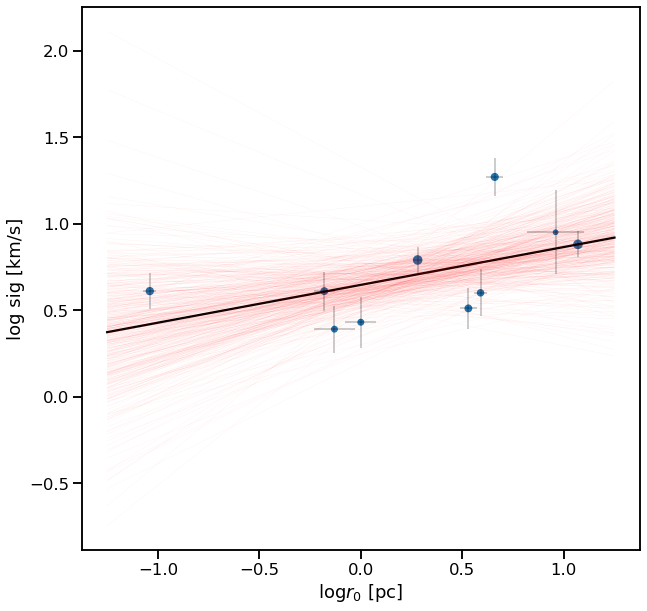

In [48]:
vmin, vmax = -1.25, 1.25
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)

    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log$ r_{0}$ [pc]", ylabel=r"log sig [km/s]",
)

In [49]:
dfchain["alpha"].mean(),dfchain["beta"].mean()

(0.6459586425138168, 0.2186756662185614)

In [50]:
dfchain["alpha"].std(),dfchain["beta"].std()

(0.12262465185090766, 0.18910979459817964)

In [51]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:         log sig [km/s]   R-squared:                       0.267
Model:                            WLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     2.917
Date:                Thu, 28 Oct 2021   Prob (F-statistic):              0.126
Time:                        20:50:34   Log-Likelihood:                0.88894
No. Observations:                  10   AIC:                             2.222
Df Residuals:                       8   BIC:                             2.827
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6827      0.080      8.570      

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


sig vs m

In [52]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log sig [km/s]', 'siger','m', 'mer']]

In [53]:
Y=np.log10(Y)

[Text(0, 0.5, 'log m'), Text(0.5, 0, 'log sig [km/s]')]

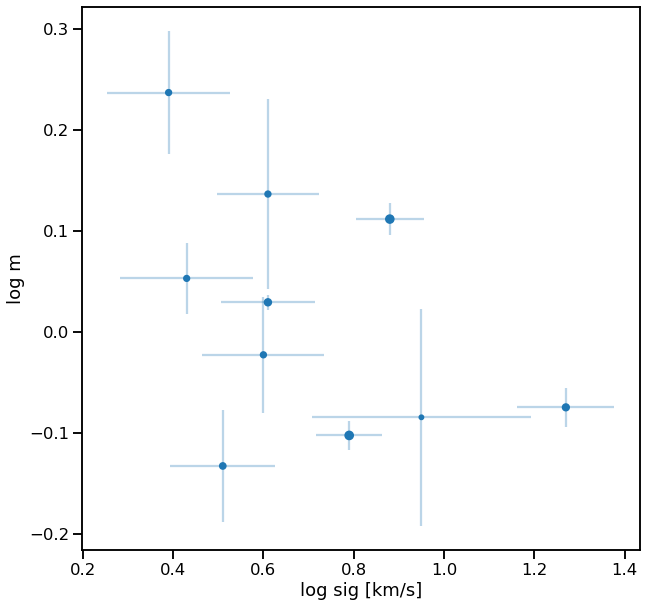

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log sig [km/s]", ylabel=r"log m",
)
#ax.set_aspect("equal")
#sns.despine()

In [55]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [56]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00731061 1.00691091 1.00236318 1.00046733 0.99902711 1.02147713]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99896907 0.99866306 1.00497884 1.00092792 0.99995999 1.0052094 ]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99996653 0.99961016 1.00193326 1.01430895 0.99987667 1.0100423 ]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99906293 0.99932867 1.0015451  1.0078585  1.00000373 1.00804673]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99897792 0.99948745 1.0018196  1.00725616 0.9999982  1.0048232 ]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00049093 1.00078423 1


Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00054806 1.00028539 1.00001167 1.00002422 0.99999622 0.99987513]


In [57]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
dfchain

,alpha,beta,sigsqr,pi,mu,tausqr,mu0,usqr,wsqr,ximean,xisig,corr
0,0.044257,-0.045974,0.017150,"[0.025462300889569953, 0.97453769911043]","[0.8846837274702246, 0.6872572014489484]","[3.700809672469401, 0.04715918904899081]",0.771914,0.011425,0.086890,0.692284,0.375708,-0.130765
1,0.252975,-0.323099,0.008443,"[0.0970569312610895, 0.9029430687389105]","[0.8152410529794557, 0.6711196900561026]","[0.1571626444344767, 0.10723502554816733]",0.867126,0.046219,0.039049,0.685108,0.337492,-0.764711
2,0.123190,-0.112767,0.008578,"[0.017698701488611867, 0.9823012985113881]","[0.5132273950017645, 0.7603554753886925]","[0.028570305978806176, 0.045833682012440015]",0.535332,0.035843,0.025364,0.755982,0.215847,-0.254179
3,0.216765,-0.240563,0.007417,"[0.15074750035732487, 0.849252499642675]","[1.112524415478533, 0.6238668990936904]","[0.023588259311466745, 0.07393428997103482]",0.861097,0.027053,0.039039,0.697531,0.311311,-0.656177
4,0.276474,-0.309898,0.006043,"[0.39984149772543126, 0.6001585022745686]","[0.9822237014108082, 0.741095326755535]","[0.018982391540926742, 0.1348111932355054]",0.784151,0.062873,0.069836,0.837508,0.320079,-0.787086
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.115978,-0.143384,0.016210,"[0.15083816957317, 0.8491618304268299]","[0.6448708437943453, 0.8615679542508371]","[0.04487159818268785, 0.06002541208947841]",0.893492,0.028644,0.030109,0.828882,0.252496,-0.273511
9996,0.097130,-0.098859,0.004258,"[0.1859233635159175, 0.8140766364840825]","[0.9159103216658488, 0.8728402030941352]","[0.21136569649824732, 0.10121741902594879]",1.014428,0.014258,0.042289,0.880848,0.349253,-0.467690
9997,0.097247,-0.086525,0.008651,"[0.3030589425915839, 0.696941057408416]","[0.8403979964194835, 1.042280178050027]","[0.07900888560450958, 0.3855724014208289]",0.965869,0.017012,0.109505,0.981098,0.548884,-0.454760
9998,0.077152,-0.074767,0.007764,"[0.4480504592756085, 0.5519495407243915]","[0.8704378559432696, 0.8486416888574683]","[0.26869045370451106, 0.15940657848871348]",0.813692,0.069157,0.138458,0.858407,0.456606,-0.361276


In [58]:
dfchain.describe()

,alpha,beta,sigsqr,mu0,usqr,wsqr,ximean,xisig,corr
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.148632,-0.189099,0.024298,0.711208,0.045144,0.078779,0.700338,0.407122,-0.332031
std,0.192453,0.258251,0.028233,0.204994,0.030322,0.084594,0.098031,2.490523,0.365035
min,-1.991333,-2.310998,0.001713,-0.575707,0.000125,0.000194,0.108675,0.075103,-0.999999
25%,0.042618,-0.327773,0.010678,0.591151,0.018853,0.023984,0.638595,0.220561,-0.609231
50%,0.144268,-0.184294,0.017109,0.709899,0.040053,0.052306,0.700427,0.277751,-0.376115
75%,0.253758,-0.049802,0.027773,0.835486,0.068794,0.103033,0.762294,0.360336,-0.098138
max,1.693698,2.542657,0.579366,1.682104,0.109808,1.306118,1.196540,150.440791,0.998549


In [59]:
pearsonr(X, Y)

(-0.43940134032592654, 0.2038798815792879)

In [60]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,0.704000,0.125147,0.014774,0.046610
std,0.270604,0.047929,0.120267,0.034507
min,0.390000,0.073739,-0.133063,0.007225
25%,0.532500,0.104907,-0.082397,0.016646
50%,0.610000,0.114571,0.003048,0.045160
75%,0.857500,0.135837,0.096806,0.059766
max,1.270000,0.242700,0.236839,0.107273


[Text(0, 0.5, 'log m'), Text(0.5, 0, 'log sig [km/s]')]

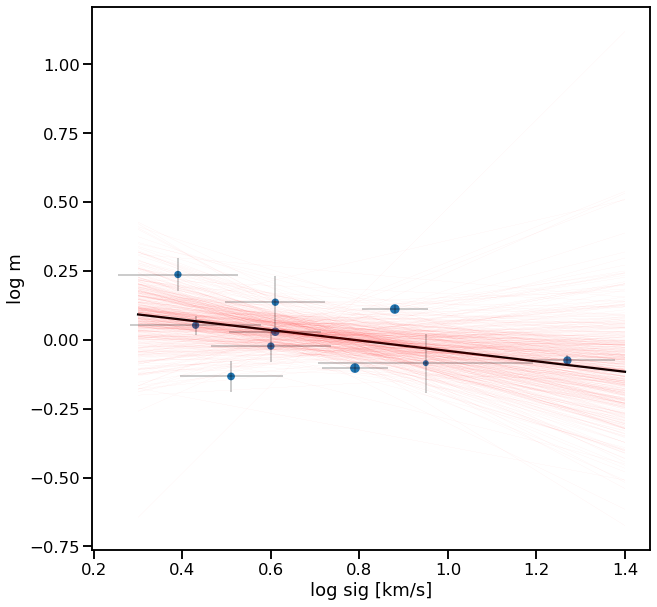

In [61]:
vmin, vmax = 0.3, 1.4
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log sig [km/s]", ylabel=r"log m",
)

In [62]:
dfchain["alpha"].mean(),dfchain["beta"].mean()

(0.14863213835500766, -0.18909935045223372)

In [63]:
dfchain["alpha"].std(),dfchain["beta"].std()

(0.19245309628813603, 0.2582509611780928)

In [64]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      m   R-squared:                       0.128
Model:                            WLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.172
Date:                Thu, 28 Oct 2021   Prob (F-statistic):              0.311
Time:                        20:50:40   Log-Likelihood:                 6.5776
No. Observations:                  10   AIC:                            -9.155
Df Residuals:                       8   BIC:                            -8.550
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1006      0.085      1.

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Diam(R) vs r0

In [65]:
X, Y, Ye = [logdata[_] for _ in ['log L [pc]', 'log r0 [pc]', 'r0er']]

[Text(0, 0.5, 'log r0 [pc]'), Text(0.5, 0, 'log R [pc]')]

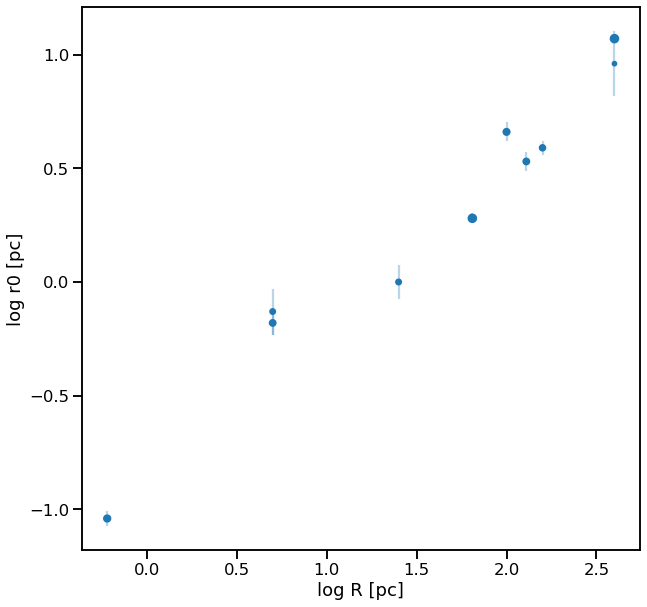

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log R [pc]", ylabel=r"log r0 [pc]",
)
#ax.set_aspect("equal")
#sns.despine()

In [67]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:            log r0 [pc]   R-squared:                       0.972
Model:                            WLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     281.1
Date:                Thu, 28 Oct 2021   Prob (F-statistic):           1.62e-07
Time:                        20:50:41   Log-Likelihood:                 4.7608
No. Observations:                  10   AIC:                            -5.522
Df Residuals:                       8   BIC:                            -4.916
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9062      0.091     -9.958      0.0

L vs sig

In [68]:
X, Y, Ye = [logdata[_] for _ in ['log L(H) [erg s^-1]', 'log sig [km/s]', 'siger']]

[Text(0, 0.5, 'log sig [km/s]'), Text(0.5, 0, 'log L(H) [erg s^-1]')]

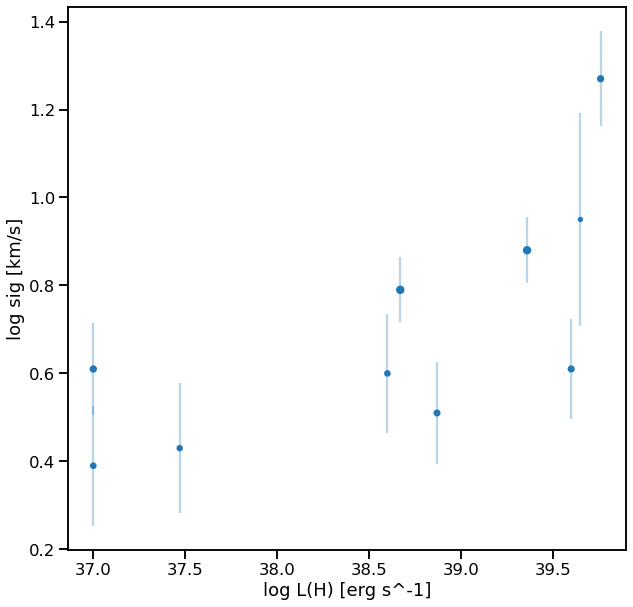

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log L(H) [erg s^-1]", ylabel=r"log sig [km/s]",
)
#ax.set_aspect("equal")
#sns.despine()

In [70]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:         log sig [km/s]   R-squared:                       0.449
Model:                            WLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     6.509
Date:                Thu, 28 Oct 2021   Prob (F-statistic):             0.0341
Time:                        20:50:41   Log-Likelihood:                 2.3110
No. Observations:                  10   AIC:                           -0.6221
Df Residuals:                       8   BIC:                          -0.01690
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.8046    

In [71]:
X, Y, Ye = [logdata[_] for _ in ['log L(H) [erg s^-1]', 'log sig [km/s]', 'siger']]

In [72]:
x,y=Y,X
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     log L(H) [erg s^-1]   R-squared:                       0.506
Model:                             OLS   Adj. R-squared:                  0.444
Method:                  Least Squares   F-statistic:                     8.184
Date:                 Thu, 28 Oct 2021   Prob (F-statistic):             0.0211
Time:                         20:50:41   Log-Likelihood:                -10.911
No. Observations:                   10   AIC:                             25.82
Df Residuals:                        8   BIC:                             26.43
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             36.5997      0.7

Distance (D) vs m

In [73]:
X, Y, Ye = [logdata[_] for _ in ['log Dist [kpc]', 'm', 'mer']]

[Text(0, 0.5, 'log m'), Text(0.5, 0, 'log Dist [kpc]')]

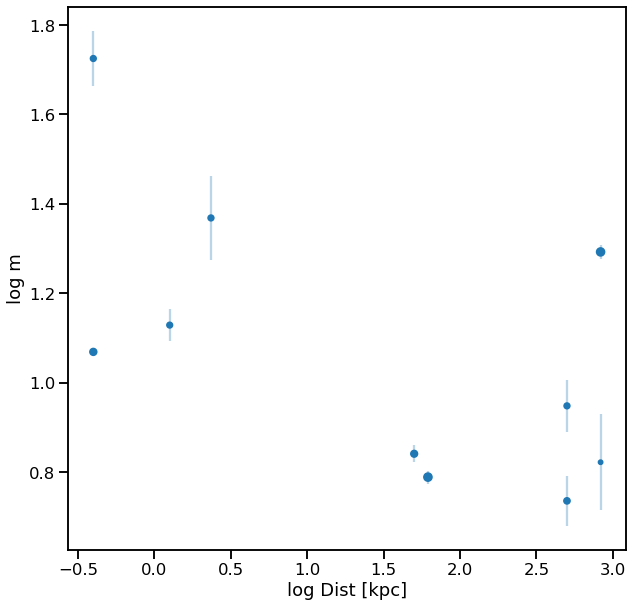

In [74]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log Dist [kpc]", ylabel=r"log m",
)
#ax.set_aspect("equal")
#sns.despine()

In [75]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      m   R-squared:                       0.012
Model:                            WLS   Adj. R-squared:                 -0.112
Method:                 Least Squares   F-statistic:                   0.09675
Date:                Thu, 28 Oct 2021   Prob (F-statistic):              0.764
Time:                        20:50:41   Log-Likelihood:                -2.6729
No. Observations:                  10   AIC:                             9.346
Df Residuals:                       8   BIC:                             9.951
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0479      0.063     16.

sig vs siglos

In [76]:
X, Y, Ye = [logdata[_] for _ in ['log siglos [km/s]', 'log sig [km/s]', 'siger']]

[Text(0, 0.5, 'log sig [km/s]'), Text(0.5, 0, 'log siglos [km/s]')]

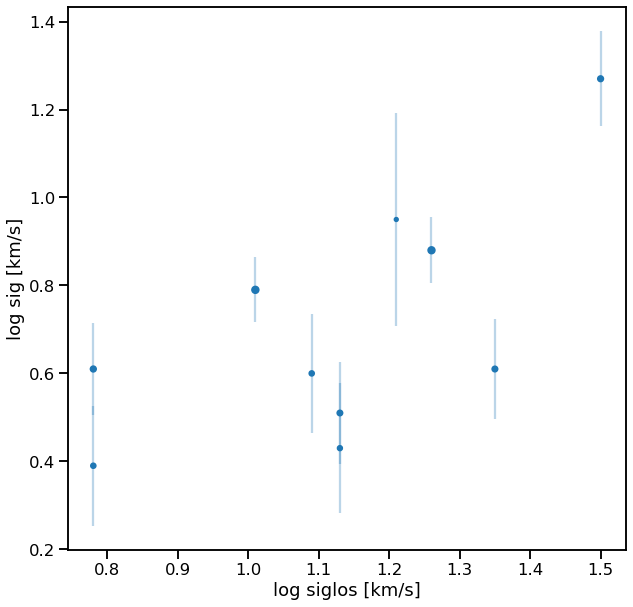

In [77]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log siglos [km/s]", ylabel=r"log sig [km/s]",
)
#ax.set_aspect("equal")
#sns.despine()

In [78]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:         log sig [km/s]   R-squared:                       0.423
Model:                            WLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     5.859
Date:                Thu, 28 Oct 2021   Prob (F-statistic):             0.0418
Time:                        20:50:42   Log-Likelihood:                 2.0819
No. Observations:                  10   AIC:                           -0.1639
Df Residuals:                       8   BIC:                            0.4413
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0638      0.34

L vs siglos

In [110]:
Moiseev=pd.read_csv('DataOthers//Moiseev2015.csv')
Ostin=pd.read_csv('DataOthers//Ostin2001.csv')
Blasco=pd.read_csv('DataOthers//Blasco2013.csv')
Rozas=pd.read_csv('DataOthers//Rozas2006.csv')
Ars=pd.read_csv('DataOthers//ArsRoy1986.csv')
Wis=pd.read_csv('DataOthers//Wis2012.csv')
Gal=pd.read_csv('DataOthers//Gallagher1983.csv')
Fer=pd.read_csv('DataOthers//Fernandez2018.csv')


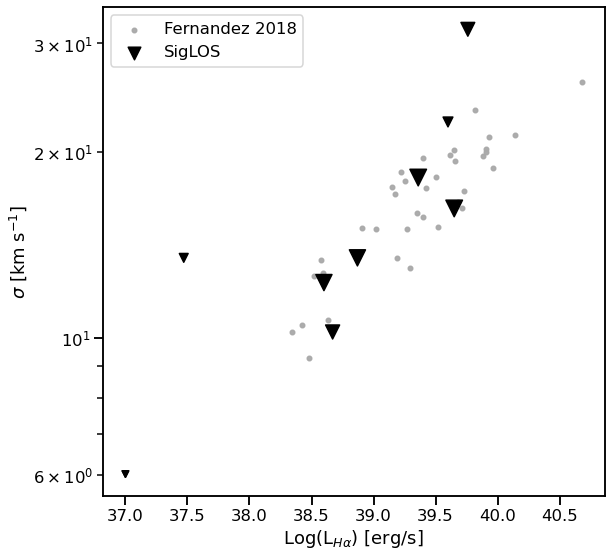

In [112]:
fig, ax=plt.subplots(figsize=(9,9))

plt.scatter(Fer.L,10**(Fer.sig),label='Fernandez 2018',marker='.',alpha=0.95,color='darkgray')

#plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log sig [km/s]']),marker='o',label='SigPOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)
plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log siglos [km/s]']),marker='v',label='SigLOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)

plt.yscale('log')

ax.set(
#    ylim  = [36, 43],
#    xlim  = [1, 150],
)
#ax.set_facecolor('whitesmoke')
ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='$σ$ [km s$^{-1}$]')
plt.legend()
#fig.savefig('SFplots//lvss.pdf', bbox_inches='tight')


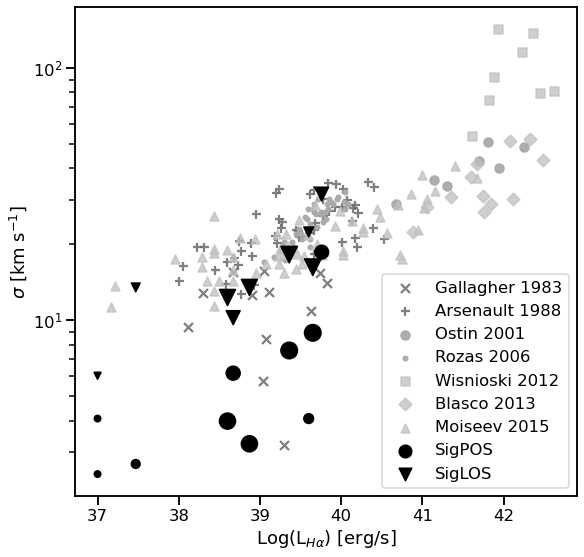

In [80]:
fig, ax=plt.subplots(figsize=(9,9))

plt.scatter(Gal.L,Gal.sig,label='Gallagher 1983',marker='x',alpha=0.85,color='dimgray')
plt.scatter(Ars.L,10**Ars.sig,label='Arsenault 1988',marker='+',alpha=0.85,color='dimgray')
plt.scatter(Ostin.L,Ostin.sig,label='Ostin 2001',marker='o',alpha=0.95,color='darkgray')
plt.scatter(Rozas.L,10**(Rozas.sig),label='Rozas 2006',marker='.',alpha=0.95,color='darkgray')
plt.scatter(Wis.L,Wis.sig,label='Wisnioski 2012',marker='s',alpha=0.75,color='silver')
plt.scatter(Blasco.L,Blasco.sig,label='Blasco 2013',marker='D',alpha=0.75,color='silver')
plt.scatter(Moiseev.L,Moiseev.sig,label='Moiseev 2015',marker='^',alpha=0.75,color='silver')

plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log sig [km/s]']),marker='o',label='SigPOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)
plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log siglos [km/s]']),marker='v',label='SigLOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)

plt.yscale('log')

ax.set(
#    ylim  = [36, 43],
#    xlim  = [1, 150],
)
#ax.set_facecolor('whitesmoke')
ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='$σ$ [km s$^{-1}$]')
plt.legend()
#fig.savefig('SFplots//lvss.pdf', bbox_inches='tight')


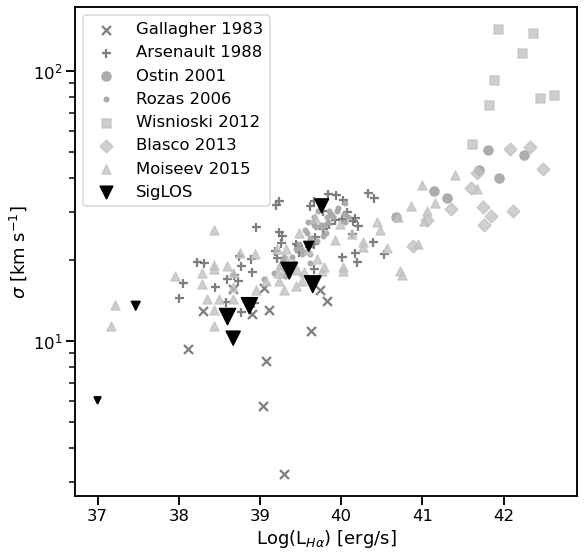

In [81]:
fig, ax=plt.subplots(figsize=(9,9))

plt.scatter(Gal.L,Gal.sig,label='Gallagher 1983',marker='x',alpha=0.85,color='dimgray')
plt.scatter(Ars.L,10**Ars.sig,label='Arsenault 1988',marker='+',alpha=0.85,color='dimgray')
plt.scatter(Ostin.L,Ostin.sig,label='Ostin 2001',marker='o',alpha=0.95,color='darkgray')
plt.scatter(Rozas.L,10**(Rozas.sig),label='Rozas 2006',marker='.',alpha=0.95,color='darkgray')
plt.scatter(Wis.L,Wis.sig,label='Wisnioski 2012',marker='s',alpha=0.75,color='silver')
plt.scatter(Blasco.L,Blasco.sig,label='Blasco 2013',marker='D',alpha=0.75,color='silver')
plt.scatter(Moiseev.L,Moiseev.sig,label='Moiseev 2015',marker='^',alpha=0.75,color='silver')

#plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log sig [km/s]']),marker='o',label='SigPOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)
plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log siglos [km/s]']),marker='v',label='SigLOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)

plt.yscale('log')

ax.set(
#    ylim  = [36, 43],
#    xlim  = [1, 150],
)
#ax.set_facecolor('whitesmoke')
ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='$σ$ [km s$^{-1}$]')
plt.legend()
#fig.savefig('SFplots//lvss.pdf', bbox_inches='tight')

In [82]:
globalL= pd.concat([Moiseev.L, Ostin.L.dropna(),Blasco.L.dropna(),Rozas.L.dropna(),Ars.L.dropna(),Wis.L.dropna(),Gal.L.dropna()], axis=0)
globalS= pd.concat([Moiseev.sig, Ostin.sig.dropna(),Blasco.sig.dropna(),10**Rozas.sig.dropna(),10**Ars.sig.dropna(),Wis.sig.dropna(),Gal.sig.dropna()],  axis=0)
GL=np.concatenate((np.array(globalL), np.array(logdata['log L(H) [erg s^-1]'])))
GS=np.concatenate((np.array(globalS), np.array(10**(logdata['log siglos [km/s]']))))

[Text(0, 0.5, 'Log$σ$ [km s$^{-1}$]'), Text(0.5, 0, 'Log(L$_{Hα}$) [erg/s]')]

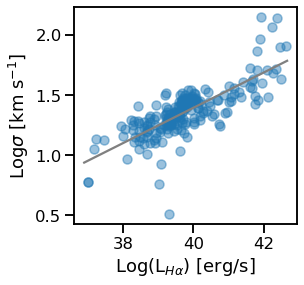

In [83]:
fig, ax=plt.subplots(figsize=(4,4))


plt.scatter(GL, np.log10(GS),alpha=0.45)

x2=np.logspace(1.567,1.63)
y2=-4.4928+0.1472*x2
plt.plot(x2,y2, color='gray')

ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='Log$σ$ [km s$^{-1}$]')


In [84]:
GSer = (GS*.05)/GS

In [85]:
GLer = (GL*.05)/GL

In [86]:
X, Xe, Y, Ye = [GL, GLer, np.log10(GS), GSer]

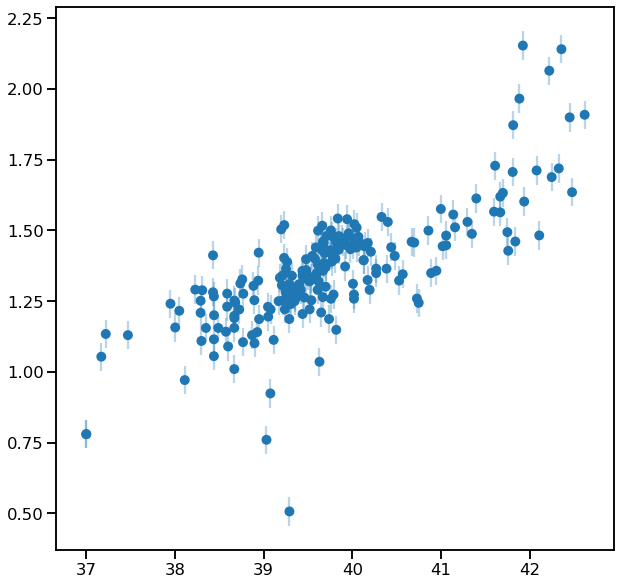

In [87]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
#plt.xscale('log')
#plt.yscale('log')

In [88]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [89]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99466315 0.99502112 1.01315318 1.01239458 1.00349172 1.01531755]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.0027364  1.00274205 1.0049984  1.00566648 1.005374   1.01865646]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99922822 0.99918591 0.99891088 1.00494669 1.00020207 1.0016351 ]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99920981 0.99920472 0.99757411 1.00411257 0.99838104 0.99799652]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99821526 0.99819666 0.99825378 1.00166216 0.998359   0.99812434]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99874934 0.99870182 0


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00006021 1.00006519 0.9999013  1.00164344 1.00001655 0.99987814]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00010815 1.00011386 0.99993548 1.00170646 1.00001913 0.99990212]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.0000324  1.00003666 0.9999206  1.0014939  1.00006054 0.99990984]


In [90]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
dfchain

,alpha,beta,sigsqr,pi,mu,tausqr,mu0,usqr,wsqr,ximean,xisig,corr
0,-4.170249,0.138982,0.013803,"[0.46739163831865876, 0.5326083616813412]","[39.874363701447315, 39.56275343318186]","[2.1268986616395025, 0.3581331045697472]",39.818362,0.116693,0.187866,39.708397,1.099551,0.792792
1,-4.299455,0.142461,0.012362,"[0.48277332688731095, 0.517226673112689]","[39.97205241525585, 39.54001746109757]","[2.3264938441068157, 0.17278391812151486]",39.546706,0.199199,0.636782,39.748592,1.122117,0.820956
2,-4.481688,0.146997,0.014643,"[0.47363674363704394, 0.526363256362956]","[40.17028996452585, 39.48082731057192]","[2.3355835909427767, 0.18448405521158948]",40.034112,0.142086,0.162169,39.807382,1.149710,0.813065
3,-4.307230,0.142641,0.015194,"[0.5426518524310934, 0.4573481475689066]","[39.968380792431375, 39.49792665252733]","[1.9245062070293588, 0.21274459428975287]",39.489669,0.060009,0.205353,39.753219,1.093876,0.784685
4,-4.789727,0.154914,0.015356,"[0.5109641796839524, 0.48903582031604753]","[39.97600481417362, 39.489693824059025]","[1.67546345121165, 0.2514875363254016]",39.907746,0.242684,0.807966,39.738181,1.018913,0.786564
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-4.586234,0.149956,0.015427,"[0.5554115090381243, 0.4445884909618757]","[39.5077257060196, 40.31796006351647]","[0.32117326541036817, 2.347536819932488]",39.311759,0.938705,1.253217,39.867947,1.176510,0.817691
9996,-4.629863,0.150381,0.014461,"[0.6103994243946944, 0.38960057560530553]","[39.54959450251292, 39.99657417902086]","[0.33661578802922887, 2.120200178503853]",39.647210,0.103851,0.362555,39.723738,1.038756,0.792399
9997,-4.411007,0.145078,0.014684,"[0.631076445543759, 0.36892355445624103]","[39.456129883926266, 40.02097716195353]","[0.4712105216469319, 2.1250414424668307]",39.775184,0.083680,0.029863,39.664515,1.075002,0.789653
9998,-4.335730,0.143214,0.015058,"[0.6161314258755342, 0.3838685741244657]","[39.510920065876945, 40.00537040346227]","[0.4476109196979802, 1.9942975763584623]",39.581789,0.040423,0.214464,39.700724,1.048408,0.774306


In [91]:
dfchain.describe()

,alpha,beta,sigsqr,mu0,usqr,wsqr,ximean,xisig,corr
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-4.504766,0.147531,0.015523,39.938606,0.653520,0.681460,39.745888,1.110002,0.794471
std,0.338995,0.008525,0.001847,0.693903,0.491627,0.557799,0.078362,0.067817,0.030011
min,-5.697176,0.117667,0.010304,37.131393,0.001983,0.006253,39.454833,0.886144,0.629739
25%,-4.731620,0.141872,0.014228,39.527168,0.234409,0.283043,39.693364,1.064268,0.774984
50%,-4.506759,0.147546,0.015387,39.824594,0.531152,0.535247,39.745027,1.107062,0.796288
75%,-4.279470,0.153295,0.016689,40.282697,1.001786,0.924339,39.797199,1.153013,0.815485
max,-3.314563,0.177697,0.023427,43.203610,1.833182,5.173289,40.033001,1.436447,0.893497


In [92]:
pearsonr(X, Y)

(0.77510211505142, 3.80228362815389e-42)

In [93]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,204.000000,2.040000e+02,204.000000,2.040000e+02
mean,39.750147,5.000000e-02,1.359637,5.000000e-02
std,1.105695,4.879636e-17,0.210025,4.875989e-17
min,37.000000,5.000000e-02,0.506911,5.000000e-02
25%,39.156000,5.000000e-02,1.252489,5.000000e-02
50%,39.640500,5.000000e-02,1.349277,5.000000e-02
75%,40.148700,5.000000e-02,1.460000,5.000000e-02
max,42.622000,5.000000e-02,2.153357,5.000000e-02


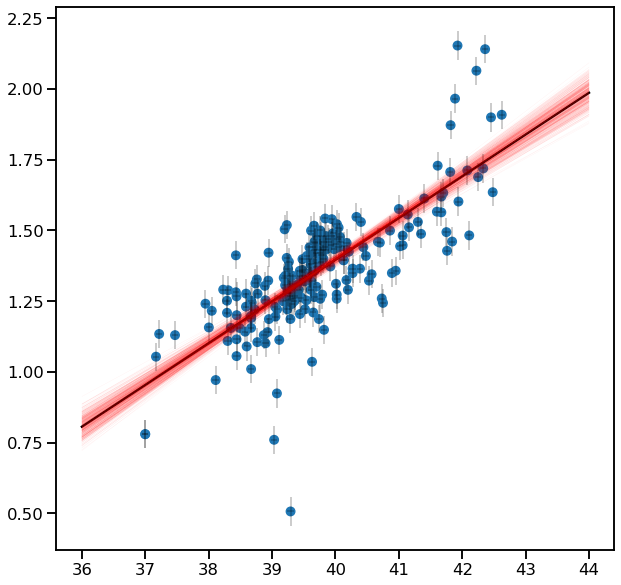

In [94]:
vmin, vmax = 36, 44
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)

In [95]:
dfchain["alpha"].mean(),dfchain["beta"].mean()

(-4.504766494872996, 0.14753063245784584)

In [96]:
dfchain["alpha"].std(),dfchain["beta"].std()

(0.33899481218667915, 0.008525142194677928)

In [97]:
x,y,z=X,Y,Ye
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.601
Model:                            WLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     304.0
Date:                Thu, 28 Oct 2021   Prob (F-statistic):           3.80e-42
Time:                        20:51:03   Log-Likelihood:                 123.05
No. Observations:                 204   AIC:                            -242.1
Df Residuals:                     202   BIC:                            -235.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4928      0.336    -13.380      0.0

In [98]:
Y, Ye, X, Xe = [GL, GLer, np.log10(GS), GSer]

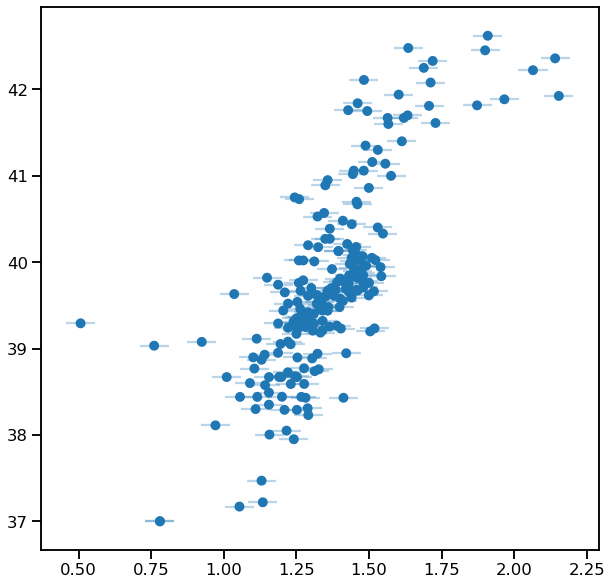

In [99]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", alpha=0.3)
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))

In [100]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [101]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00056903 1.00143102 0.99747155 0.99406684 0.99229639 0.99298716]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99794813 0.99847945 0.99848258 1.00288599 0.99606511 0.99825666]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99768817 0.99751317 1.00106638 1.00349168 1.00271666 1.00110552]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99779118 0.99769282 0.99984576 1.00227418 1.00208393 0.99950519]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99810605 0.99807429 0.99965304 1.00270095 1.00450455 1.00229941]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99846133 0.99846375 0


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99995265 0.99994254 1.00011308 1.00008046 1.00024309 0.99985532]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99992606 0.99991594 1.00009545 1.000067   1.00017173 0.99983657]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99993955 0.99993009 1.00015777 1.00001511 1.00014618 0.99982287]


In [102]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
dfchain

,alpha,beta,sigsqr,pi,mu,tausqr,mu0,usqr,wsqr,ximean,xisig,corr
0,34.270929,4.019979,0.465378,"[0.19547016801893788, 0.8045298319810622]","[1.4180168687377537, 1.348974953948138]","[0.1896983166000966, 0.011847232336981903]",1.526421,0.018357,0.034741,1.362471,0.217627,0.788590
1,33.527039,4.576962,0.431280,"[0.23039331254804288, 0.769606687451957]","[1.4328760557003228, 1.3451776241055446]","[0.09787855771394711, 0.012188510012512149]",1.447471,0.016584,0.043583,1.365383,0.182468,0.786076
2,33.740339,4.393130,0.359003,"[0.20638670561244138, 0.7936132943875587]","[1.3855012789323993, 1.3374027197566793]","[0.13580405236941961, 0.01584203775042492]",1.210289,0.013998,0.014443,1.347330,0.202434,0.829334
3,33.878856,4.377256,0.518487,"[0.18906065899307273, 0.8109393410069272]","[1.3611063064811222, 1.3374754379982774]","[0.15420484583722124, 0.01567701824829486]",1.419941,0.016099,0.049179,1.341943,0.204824,0.779676
4,33.705117,4.499847,0.441842,"[0.17640820407505084, 0.8235917959249492]","[1.3496381801001023, 1.331626899114423]","[0.12670838969653467, 0.013909177817402387]",1.401976,0.065227,0.047102,1.334804,0.183997,0.779791
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,34.006152,4.225357,0.453511,"[0.8206167808274641, 0.17938321917253583]","[1.3337915606519708, 1.4548735178947991]","[0.01841045115859569, 0.12077164517048618]",1.490840,0.047584,0.032393,1.355512,0.197308,0.777913
9996,33.801261,4.428954,0.419613,"[0.8543687679163428, 0.1456312320836573]","[1.3213526131426898, 1.3960427472718957]","[0.015831880481372074, 0.1795750328886989]",1.249427,0.014518,0.012900,1.332230,0.200928,0.808488
9997,33.438449,4.683036,0.465027,"[0.8394865900009387, 0.16051340999906144]","[1.325456112013236, 1.422273654133794]","[0.020247659695103084, 0.15636721976683748]",1.269685,0.006695,0.020659,1.340997,0.208230,0.819498
9998,33.875489,4.344362,0.448170,"[0.8408362195435567, 0.15916378045644325]","[1.3420415493235816, 1.3583337187053541]","[0.01453894454781017, 0.10490829832723964]",1.353005,0.013556,0.028626,1.344635,0.170170,0.741246


In [103]:
dfchain.describe()

,alpha,beta,sigsqr,mu0,usqr,wsqr,ximean,xisig,corr
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,33.936306,4.276363,0.469984,1.376193,0.022420,0.036753,1.358493,0.208641,0.790036
std,0.350900,0.254991,0.052216,0.109905,0.016623,0.028662,0.014925,0.019853,0.036571
min,32.571195,3.288783,0.319628,0.843519,0.000222,0.000423,1.292462,0.153990,0.631917
25%,33.703936,4.107894,0.433388,1.313031,0.009027,0.015867,1.348436,0.194710,0.765968
50%,33.939659,4.273470,0.467085,1.373230,0.017927,0.029421,1.358374,0.206722,0.791694
75%,34.171725,4.445125,0.502613,1.437130,0.033118,0.049860,1.368453,0.220358,0.815800
max,35.334954,5.253255,0.694392,1.909694,0.066092,0.254480,1.422472,0.329196,0.900637


In [104]:
pearsonr(X, Y)

(0.77510211505142, 3.80228362815389e-42)

In [105]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,204.000000,2.040000e+02,204.000000,2.040000e+02
mean,1.359637,5.000000e-02,39.750147,5.000000e-02
std,0.210025,4.875989e-17,1.105695,4.879636e-17
min,0.506911,5.000000e-02,37.000000,5.000000e-02
25%,1.252489,5.000000e-02,39.156000,5.000000e-02
50%,1.349277,5.000000e-02,39.640500,5.000000e-02
75%,1.460000,5.000000e-02,40.148700,5.000000e-02
max,2.153357,5.000000e-02,42.622000,5.000000e-02


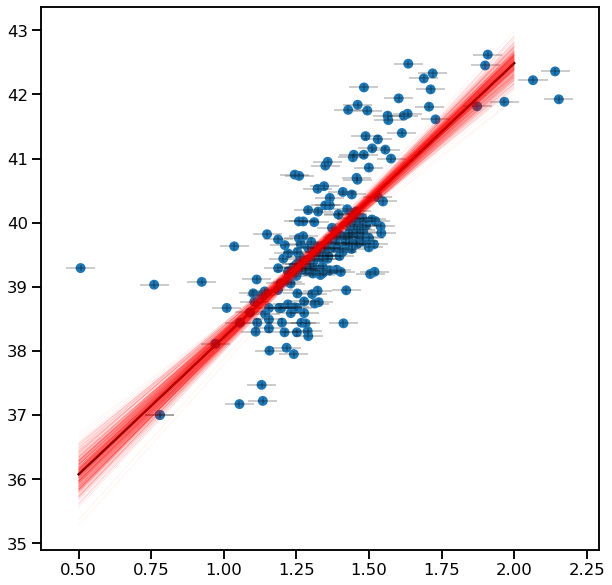

In [106]:
vmin, vmax = 0.5, 2
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.4, lw=0.1)


In [107]:
dfchain["alpha"].mean(),dfchain["beta"].mean()

(33.936306146793065, 4.27636294779967)

In [108]:
dfchain["alpha"].std(),dfchain["beta"].std()

(0.35089975561898246, 0.25499088374902523)

In [109]:
print("--- %s seconds ---" % (time.time()-start_time))


--- 81.76881575584412 seconds ---
